In [147]:
import numpy as np
from getting_analytical_data import get_anal_data
from numba import njit,jit
import matplotlib.pyplot as plt
import sys
from scipy.sparse import csr_matrix,csc_matrix
import scipy as sp
import time
from tqdm import tqdm

In [2]:
N,times,rs_linspace,thetas_linspace,rs,thetas,Z_anal = get_anal_data()
dt_anal = times[1]
dr_anal = rs_linspace[1]
dtheta_anal = thetas_linspace[1]

100%|██████████| 651/651 [01:39<00:00,  6.57it/s]


In [143]:
# takes NxN matrix, returns 1xN^2 flattened matrix. u[i,j] --> u[i+Nj=k]
# @jit(forceobj=True)
@njit
def flatten(matrix):
#     return matrix.reshape(-1)
    size = len(matrix)
    line = np.zeros((size**2))
    count = 0
    for i in list(range(size)):
        for j in list(range(size)):
            line[count] = matrix[i,j]
            count += 1
    return line

@jit(forceobj=True)
def unflatten(line):
#     size = int(np.sqrt(np.size(line)))
    size = int(np.sqrt(len(line)))
    return line.reshape(size,size)

@njit
def get_A(dt,dr,dtheta):
    A = np.zeros((N**2,N**2))
    
    ctr2 = (dt / dr)**2
    ctrt2 = (dt / (dr*dtheta))**2
    
    for k in list(range(N**2)):
        j = k % N 
        i = int(np.floor(k / N))
        
        # coeffs for u[i,j]
        A[k,k] = 2 + ctr2 - 2*ctrt2/((i+1)**2)

        # coeffs for u[i+1,j]
        if k < N**2-1:
            A[k,k+1] -(2+1/(i+1))*ctr2

        # u[i+2,j]
        if k < N**2-2:
            A[k,k+2] = (1+1/(i+1))*ctr2

        # u[i,j-1]
        if k >= N:
            A[k,k-N] = ctrt2/((i+1)**2)
        
        # u[i,j-2]
        if k >= 2*N:
            A[k,k-2*N] = ctrt2/((i+1)**2)
            
    return A

@njit
def set_BC(matrix,time):
    new_mat = matrix
    for i in list(range(len(thetas_linspace))):
        theta = thetas_linspace[i]
        new_mat[N-1,i] = np.cos(time) * np.cos(theta)
        
    return new_mat

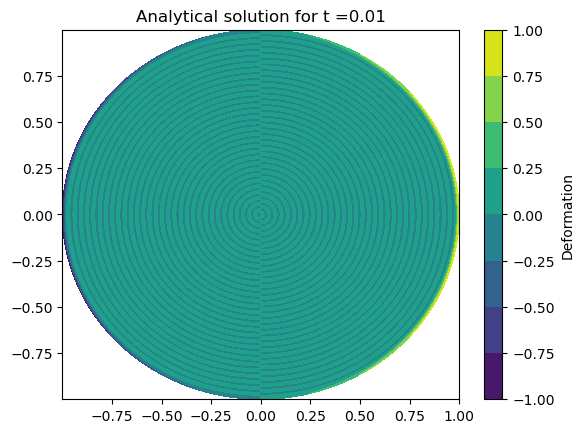

In [190]:
X = rs * np.cos(thetas)
Y = rs * np.sin(thetas)

t = 1
Zi = Z_anal[:,:,t]
levels = np.linspace(-6,6,500)
plt.figure()
contour = plt.contourf(X, Y, Zi, cmap='viridis')
colorbar = plt.colorbar(contour)
colorbar.set_label('Deformation')
plt.title("Analytical solution for t ="+ str(t/100));

In [139]:
A = get_A(1e-5,dr_anal,dtheta_anal)

A_sparse = csc_matrix(A)
A_sparse_inv = sp.sparse.linalg.inv(A_sparse) # 3 mins
A_inv = A_sparse_inv.toarray()

In [221]:
Z0 = Z_anal[:,:,0]
Z_num = Z0

dt_num = 1e-5
total_time = dt_num

Z0_flat = flatten(Z0)
Z1_flat = np.matmul(A_inv,Z0_flat)


Z_last_flat = Z1_flat
for i in tqdm(range(41)):
    total_time = round(dt_num + total_time,5)
    
    Z_next_flat = np.matmul(A_inv,Z_last_flat) - Z_last_flat
    Z_next = set_BC(unflatten(Z_next_flat),total_time)
    
    Z_last_flat = flatten(Z_next)

    if total_time % 0.01 == 0:
        Z_num = np.dstack((Z_num,Z_next))

np.save("./Z_iterative.npy",Z_num)

100%|██████████| 41/41 [00:12<00:00,  3.33it/s]


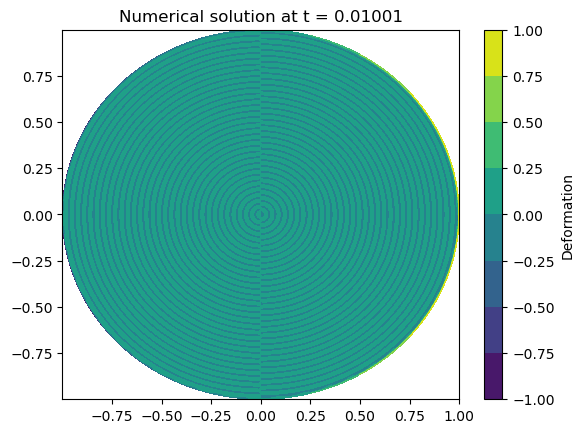

In [161]:
plt.figure()
contour = plt.contourf(X, Y, numerical_sol, levels=levels, cmap='viridis')
colorbar = plt.colorbar(contour)
colorbar.set_label('Deformation')
plt.title("Numerical solution at t = " + str(round(total_time,6)));

/tmp/ipykernel_3454767/321694640.py:2: RuntimeWarning: divide by zero encountered in divide
  contour = plt.contourf(X, Y, numerical_sol / Z_anal[:,:,1], cmap='viridis')
/tmp/ipykernel_3454767/321694640.py:2: RuntimeWarning: invalid value encountered in divide
  contour = plt.contourf(X, Y, numerical_sol / Z_anal[:,:,1], cmap='viridis')


Text(0.5, 1.0, 'Division comparison at t = 0.01001')

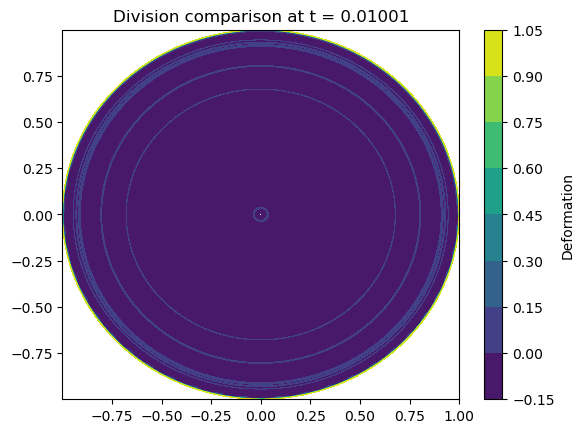

In [164]:
plt.figure()
contour = plt.contourf(X, Y, numerical_sol / Z_anal[:,:,1], cmap='viridis')
colorbar = plt.colorbar(contour)
colorbar.set_label('Deformation')
plt.title("Division comparison at t = " + str(round(total_time,6)))

In [135]:
dt_max = 0.5*dr_anal**2
print(f"{dt_max = }")

dt_max = 1.262594378929825e-05


In [127]:
np.shape(q)

(1, 40000)

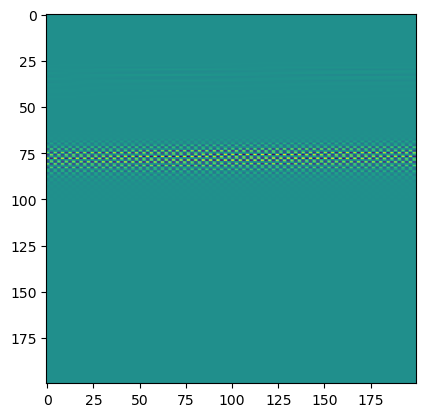

In [138]:
plt.imshow(unflatten(Z1_flat))

(40000,)

np inverse will take 14.085 minutes 
sp inverse will take 2.911 minutes 


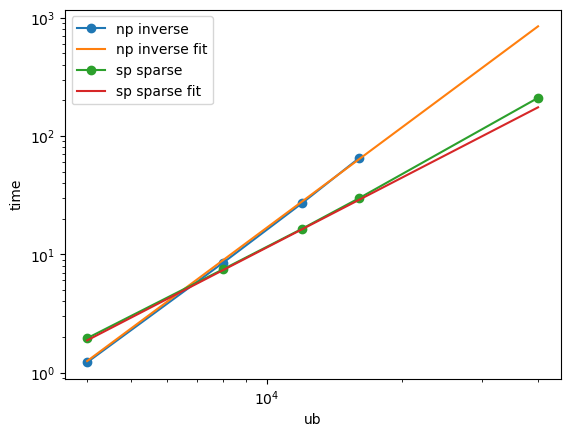

In [94]:
ubs = np.array([4000, 8000, 12000, 16000,39999])
ts = np.array([1.22, 8.45, 27.12, 64.52,None])
ts_sparse = np.array([1.95, 7.45,16.46, 29.62,210])

plt.figure()

# np inverse 
plt.loglog(ubs,ts,'-o')

# plt.xlim(3000, 40000)
# plt.ylim(1,200)

plt.xlabel("ub")
plt.ylabel("time")

xx = np.linspace(4000,200**2,10)
yy = 8e-11 * xx**(2.83)
plt.loglog(xx,yy)

plt.loglog(ubs,ts_sparse,'-o')
yyy = 1.5e-7 * xx**(1.97)
plt.loglog(xx,yyy)

plt.legend(["np inverse","np inverse fit","sp sparse", "sp sparse fit"])
print("np inverse will take",str(round(max(yy)/60,3)),"minutes ")
print("sp inverse will take",str(round(max(yyy)/60,3)),"minutes ")

In [35]:
tic = time.time()

ub = round(0.3*(N**2 - 1))
print("ub = ",ub)
A_inv = np.linalg.inv(A[0:ub,0:ub])

toc = time.time()
print(round(toc-tic,2),"seconds")

print((toc-tic) / 8.37)

ub =  12000
27.12 seconds
3.2396840650405796


In [163]:
np.inf

inf

Text(0.5, 1.0, 'Division comparison at t = 0.00042')

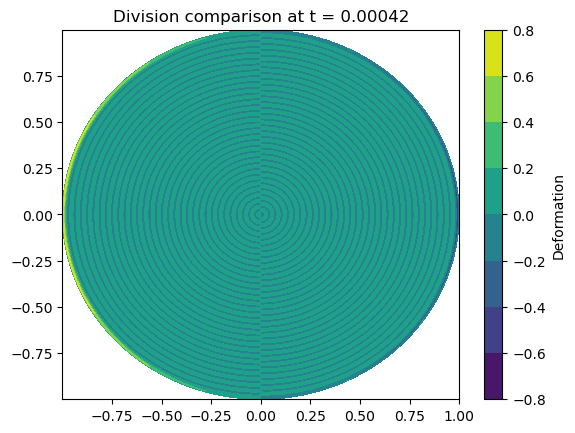

In [188]:
a = numerical_sol - Zi

            
            
plt.figure()
contour = plt.contourf(X, Y, a, cmap='viridis')
colorbar = plt.colorbar(contour)
colorbar.set_label('Deformation')
plt.title("Division comparison at t = " + str(round(total_time,6)))

In [199]:
a = np.array([[1, 2], [3, 4]])

a = np.dstack((a,a))

In [219]:
np.shape(Z_anal)

(200, 200, 651)

In [207]:
round(0.00013000000000000002,5)

0.00013